# CSCI E-25    
## Introduction to Machine Learning and Linear Models

### Steve Elston   

## Introduction to Linear Models 

The concept of the linear model is the basis of many statistical and machine learning models. Further, an understanding of linear models is a good basis for understand many other types of statistical and machine learning models.   

In this lesson we will focus on linear classification models, but the lessons drawn from this discussion can be applied to many other types of ML models. By developing an understanding of linear models, you are building a foundation to understand many other machine learning models. Nearly all machine learning methods suffer from the same problems, including over-fitting and mathematically unstable fitting methods. Understanding these problems in the linear regression context will help you work with other machine learning models.     

The method of regression is one of the oldest and most widely used analytics methods. The goal of regression is to produce a model that represents the **best fit** to some observed data. Typically the model is a function describing some type of curve (lines, parabolas, etc.) that is determined by a set of parameters (e.g., slope and intercept). *Best fit* means that there is an optimal set of parameters which minimize an error criteria we choose.     

Many machine learning models, including some of the latest deep learning methods, are a form of regression. **Linear regression** is the foundational form of regression. Linear regression minimizes squared error of the predictions of the dependent variable using the values of the independent variables. This approach is know as the **method of least squares**.   

Linear classifiers are an extension of linear regression. The linear output is transformed to a categorical probability distribution. The category with the highest probability is typically selected as the final result.  

## Load and Prepare MNIST image Data    

We will now work through an example of using a linear classifier for image classification. For this example we will use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) image data set. MNIST is a commonly used benchmark standard data set used for image classification research. The dataset is comprised of $28 \times 28$ images of hand written digits in the set $[0-9$. There are 60,000 training images and labels and 10,000 test images and labels.            

To get started, execute the code in the cell below to import the packages you will require for this example.  

In [1]:
import numpy as np
import pandas as pd
import numpy.random as nr
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras import utils as ku
import sklearn.linear_model as sklm
import sklearn.metrics as metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import skimage.feature as feature

In [2]:
import sklearn
sklearn.__version__

'1.4.1.post1'

The MNIST dataset is built into Keras with the training and test subsets of images and labels returned in lists. Execute the code in the cell below to load these subsets. 

> **Note:** The MNIST data contain simple images of hand written digits. These images are properly cropped and have nearly binary light (digit) and dark (background region) areas. No significant adjustment or transformation of these images is required. 

In [3]:
(raw_train_images, train_labels), (raw_test_images, test_labels) = mnist.load_data()
print(raw_train_images.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


> **Exercise 4-1:** It is useful to get a feeling for what this image data really looks like. On a $5 \times 5$ grid display the first 25 gray-scale training images. Give each image display a title with the label for that image or case. 

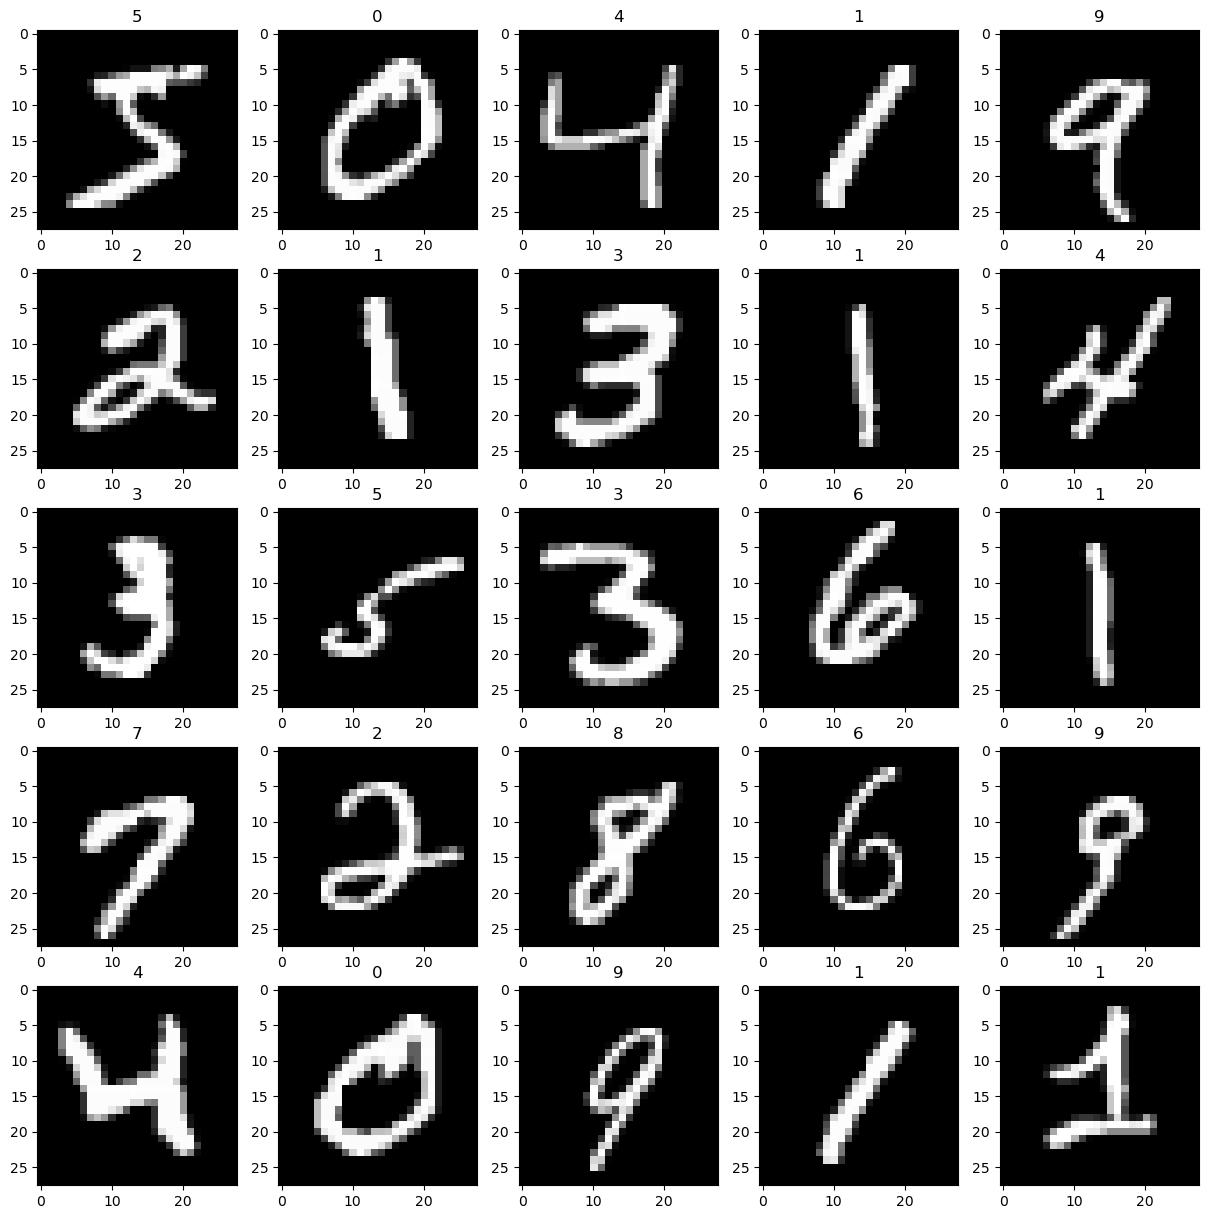

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))
ax = ax.flatten()

## Your code goes below
for i in range(0,25):
    ax[i].imshow(raw_train_images[i,:,:], cmap='gray')
    ax[i].set_title(train_labels[i])



> Examine the images and the labels. What problems can you foresee when a machine learning algorithm attempts to learn to classify the digits shown in these images? Your answer need only be 1 to 3 well chosen sentences.             
> **End of exercise.**

> **Answer:**  
The numbers are not always oriented vertically. Some are slanted. The numbers are also not written in a consistent style (for example the last two 1s are very different, one is sans-serif and the other is serif).

In order to perform machine learning with image data you must transform the data to a structure with all the **features** for each image in one row of a **model matrix**. The linear model can then be written:      

$$X b = y$$

where:    
$X$ is the model matrix with the features values for each image in the rows.    
$b$ is the **coefficient vector**, with one coefficient per feature.   
$y$ is the vector of the **labels** which encode the categories of the objects in the images.

The goal is to estimate the vector of **coefficients**, **parameters** or **weights** to **minimize errors** in the the prediction of the label, $y$, given the model matrix, $X$. In machine learning terminology, we say that the model **learns the weights**, $b$, to minimize the errors.     

For this example, we will use the values of the pixels as our feature values. This requires the 2-dimensional images be **flattened** into feature vectors. This concept is illustrated in the figure below.   

<img src="img/FlatteningImge.JPG" alt="Drawing" style="width:600px; height:300px"/>
<center>Flattening an image to a feature vector</center>

> **Exercise 4-2:** You will now flatten the the $28 \times 28$ images to feature vectors. Do the following:    
> 1. Print the shape of the training image array, noticing that each image is a 2-dimensional sub-array.   
> 2. Flatten the images to an array of 60,000 rows using [numpy.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). The image arrays are 8 bit integers. Convert them to floating point in the range $[0.0 - 1.0]$, which will normalize the feature values.    
> 3. Print the shape of the flattened image array.   
> 4. Apply the same transformations to the test image array and print the shape of the resulting array.  

In [16]:
## Your code goes below
print(raw_train_images.shape)
train_images = np.reshape(raw_train_images, (raw_train_images.shape[0],784))/256
print(train_images.shape)
test_images = np.reshape(raw_test_images, (raw_test_images.shape[0],784))/256
print(test_images.shape)

(60000, 28, 28)
(60000, 784)
(10000, 784)


> Examine the dimensions of the flattened arrays. How many features will your model have? Your answer should show a simple numeric calculation.    
> **End of exercise.**

> **Answer:**     
My model will have 784 features per image. This is because the original image is 28x28 pixels, and each pixel is a feature.

It can be instructive to look at the feature matrix. Execute the code in the cell below and examine the results.  

train_images.shape = (60000, 784)


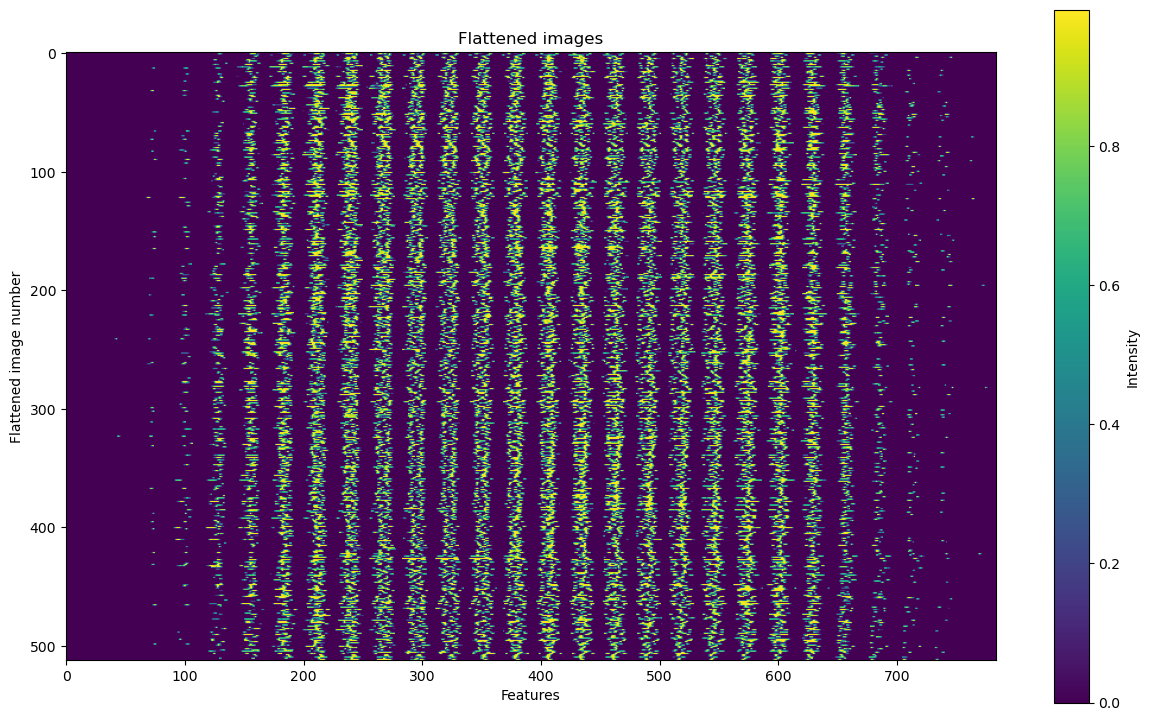

In [17]:
def plot_feature_sample(img, nrows=512):
    fig, ax = plt.subplots(figsize=(15,9))
    p = ax.imshow(img[:nrows,:])
    plt.ylabel('Flattened image number')
    plt.xlabel('Features')
    plt.title('Flattened images')
    cb = plt.colorbar(p)
    _=cb.set_label('Intensity')

print('train_images.shape = ' + str(train_images.shape))
plot_feature_sample(train_images)    

> **Exercise 4-3:** Examine the feature columns in the array displayed above. Notice the differing ranges of values in the features. What does this tell you about the scale differences and the problems this might create in model training? Your answer need only be 1 to 3 well chosen sentences.           

> **Answer:**     
The features are organized into distinct bands of values. This larger pattern of bands will make the images look more similar to each other, so the model will have to look for smaller features to distinguish images, which is sensitive to noise.

The significant difference in scale or value range of the features or pixel locations can lead to problems with model generalization. The coefficients computed will be affected by scale which will affect model performance and generalization. For example, consider that a bit of noise in some images presented to the classifier in production can lead to a high probability of erroneous classifications only as a result of scale differences. 

> **Note:** The behavior of low variance (small scale) features seen in this example may arise from the way the digit images are cropped. There are several approaches we could try here. 
> 1. Simply filter features with low variance (or small scale). The results may be a feature set with higher information content per feature.         
> 2. Transform the features so that they are all at the same scale.      
> 3. Once one of the above methods are applied to the features, dimensionality reduction might be useful. For linear models principle compomonent analysis (PCA) will typically be used.   
> **In other words, you must expolore and understand the nature of the data before applying any preprocessing step!**        

There are a number of methods we could use to deal with the scale problem. In this case, we will try the simplest possible approach, mean-variance scaling. Mean-variance scalling centers, or zero means, each feature. The centered feature values are then devided by the standard deviation, $\sigma$. For each feature $x$ we can express mean-variance scaling as follows: 

$$x_{scaled} = \frac{x - \bar{x}}{\sigma(x)}$$

Once the mean-varaince scaling is applied all features have zero mean and unit variance.   

The code in the cell below follows the usual process for mean-variance scaling:   
1. The [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is instantiated and fit to the traning data.    
2. The scaler is apply to the training data.     
3. The same scaler is apply to the test data. Note that it is important to use only the scalar learned from the training data to avoid bias.     
Execute the code in the cell below.  

In [18]:
scalar = StandardScaler().fit(train_images)
train_images = scalar.transform(train_images)
test_images = scalar.transform(test_images)

## A Linear Model        

With the feature arrays prepared, it is time to construct the machine learning model. The code in the cell below defines the linear **logistic regression** model object and fits it to the training data. Here we use the Scikit-Learn [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) function. The model definition has several key aspects:   
- L2 regularization with a hyperparameter $C = 10.0$.  
- Since there are 10 categories of digits, the multinomial probability distribution is used.    
- An efficient solver for the system of linear equations is selected.    

The `fit` method with the arguments of the model (feature) matrix and the label vector.  

If you are just learning to use Scikit-Learn it is useful to know that the general approach is used for all machine learning models available in the package. A model object is defined including the values of hyperparameters. A fit method is used to compute model parameters or weights using the model matrix and labels as the arguments. The model matrix has the features in the columns, and the cases, in this case flattened images, in the rows. You can find a [Getting Started Guide](https://scikit-learn.org/stable/getting_started.html) in the Scikit-Learn documentation.   

The code in the row below constructs the model object and fits a model. You can see that some `l2` regularization is applied with an hyperparameter of 0.1. Since this is a mutli-class classification problem, the `multi_class='multinomial'` argument is used. Now, execute the code in the cell below to create a model object.  

> **Note:** Depending on your environment, you may need to change the solver to achieve convergence of the linear model. If you encounter this problem, uncomment the line of code below, and comment out the other line. 

In [20]:
C=0.1
LinearClassifier = sklm.LogisticRegression(penalty='l2', C=C, multi_class='multinomial', solver ='lbfgs', max_iter=1000).fit(train_images, train_labels)

> **Exercise 4-4:** The logistic regression model computes probabilities each of the categories for each case. You will now investigate an example by the following steps:    
> 1. Apply the `predict_proba` method with the test images to the trained classifier method. 
> 2. Display the first 10 rows of the resulting array of probabilities.    
> 3. Sum the probabilities in the array across the classes.  

In [24]:
## Your code goes below
predictions = LinearClassifier.predict_proba(test_images)
print(predictions[0:10])
sum(sum(predictions)/len(predictions))

[[3.88258398e-07 1.37633909e-13 3.82784129e-08 3.62583552e-03
  2.30707531e-08 1.27636392e-05 2.98376380e-11 9.96224180e-01
  6.44368190e-06 1.30327591e-04]
 [2.14691591e-06 1.33228762e-07 9.84067301e-01 1.55312033e-07
  3.20277698e-21 5.64017010e-04 1.53661533e-02 1.27083492e-24
  9.32992637e-08 2.18569038e-20]
 [1.32326598e-07 9.90256581e-01 6.05747315e-03 6.56130286e-04
  3.36850057e-05 4.77638717e-04 3.68295838e-04 6.28222215e-04
  1.40936294e-03 1.12478220e-04]
 [9.99931610e-01 1.05779266e-11 8.49263881e-06 4.46427803e-07
  6.09989567e-09 3.32929297e-06 5.25609728e-05 1.08047833e-06
  7.72214041e-07 1.70161340e-06]
 [8.55352438e-05 1.43041823e-07 5.11126711e-04 3.66815801e-06
  9.67191182e-01 2.05993345e-05 7.56023731e-04 1.75995071e-03
  6.00206297e-04 2.90715643e-02]
 [3.70517274e-08 9.92425870e-01 1.68680303e-03 6.31611438e-04
  3.35515593e-06 1.86592939e-05 3.63037865e-06 3.95119133e-03
  1.06136722e-03 2.17475351e-04]
 [1.30682124e-07 7.48421566e-09 1.12738620e-07 4.18563093e

0.999999999999999

> Answer the following questions in 1 to 3 well chosen sentences:  
> 1. Examine the probabilities of the categories for each of the 10 cases. Is there generally a category with the highest probability? Are there cases where another cases has a reasonably high probability?   
> 2. Given your answers to the foregoing question, do you expect this classifier to make errors in identifying the categories?   
> 3. Are these proper probability distributions, in the sense that they sum to 1.0 for each case?  
> **End of exercise.**

> **Answers:**
> 1.    yes, there is generally a category with a high probability (e-1) but there are some that are close (e-2)
> 2.    Yes, I expect some errors 
> 3.    Yes, they sum to 1 

While it is useful to understand how the linear model algorithm computes probabilities for the categories of digits, for most applications we really only want to know the most probable category. The algorithm is quite simple; pick the category with the highest probability. Scikit-Learn provides the `predict` method that computes the probabilities are returns the category with the highest probability. Execute the code in the cell below to see an example.   

In [25]:
class_predictions = LinearClassifier.predict(test_images)
class_predictions[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=uint8)

## Evaluate the Model       

Now that you have a model and made predictions it is time to evaluate the model. The [Scikit-Learn metrics package](https://scikit-learn.org/stable/modules/model_evaluation.html) contains numerous functions for evaluating different types machine learning models. 

A widely used metric for evaluating classifiers; the number of correctly classified cases divided by all cases:   

$$Accuracy = \frac{TP}{TP + FP + TN + FN}$$    

Where, $TP$ are the true positives, $FP$ are the false positives, and $FN$ are the false negatives. In the **multi-class** case, we count all elements on the diagonal of the confusion matrix as true positive (TP). All cases on the diagonal are corrected classified in one category or another. Thus for computing average accuracy for the multi-class case there are only true positive cases in the numerator of the formula. You can find more details in [this review paper](https://arxiv.org/abs/2008.05756).    

In this case we will focus on evaluation of the multi-class classifier. The [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) computes the accuracy given the actual labels and the predicted values. Execute the code in the cell below and examine the result.         

In [26]:
print(metrics.accuracy_score(test_labels, class_predictions))

0.9273


The overall accuracy of the model seems reasonably good. However, one must be extremely careful when evaluating any machine learning model. Any single metric can be quite misleading. It is good practice to look at several views of model performance.   

The **confusion matrix** can be a powerful tool for evaluating classifiers. The confusion matrix is a 2-dimensional array with the label values on vertical axis and the predicted values on the horizontal axis. The count of correctly classified cases for each category are along the diagonal. Counts or incorrectly classified cases are found off the diagonal. 

The confusion matrix can be computed and displayed numerically. For large numbers of categories a visualization of the confusion matrix can be useful. By studying the confusion matrix one can identify many problems which would not be apparent from one to two simple metrics. For example, accuracy of a classifier might seem quite high, but it could be misclassifying all members of some category, while doing well with other categories. Only by examination of the confusion matrix can such problems be discovered.     

The code in the cell does the following:  
1. Computes the multi-class confusion matrix using the [sklearn.metrics.multilabel_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html?highlight=multilabel_confusion_matrix) function. 
2. displays the confusion matrix as a Pandas data frame to improve formatting.   
2. Displays the log values of the confusion matrix as an image or heat map. The logarithm is used in this case since the off-diagonal terms are quite small compared to the diagonal terms. A 1 is added to all terms to allow computation of the logarithm, adding a small but negligible bias.     

Execute the code and examine the results. 

     0     1    2    3    4    5    6    7    8    9
0  954     0    2    2    0   10    7    4    1    0
1    0  1111    6    2    0    2    3    1   10    0
2    9     6  924   16   11    5   13    7   38    3
3    3     1   16  927    2   21    2   11   21    6
4    1     3    8    3  920    0    7    6    6   28
5    7     4    2   33    9  778   15    8   32    4
6    9     3    7    2    6   13  915    1    2    0
7    1     8   24    6    4    1    0  951    3   30
8    9    10    5   21    8   24    9   10  866   12
9    7     8    2    9   18    7    0   23    8  927


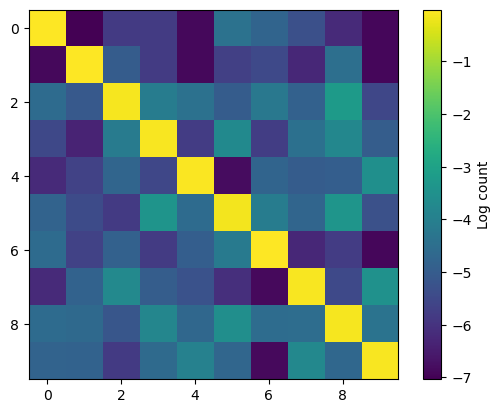

In [27]:
confusion_matrix = metrics.confusion_matrix(test_labels, class_predictions)   
print(pd.DataFrame(confusion_matrix))
p = plt.imshow(np.log(np.divide(confusion_matrix + 1.0, np.sum(confusion_matrix, axis=1))))
cb = plt.colorbar(p)
_=cb.set_label('Log count')

Some other commonly used [performance metrics for classifiers](https://en.wikipedia.org/wiki/Precision_and_recall) are **Precision** and **Recall**. For binary classifiers these metrics are defined:   

\begin{align}
Recall &= \frac{TP}{TP + FN}\\
Precision &=  \frac{TP}{TP + FP}
\end{align} 

You can think of recall as the fraction of positive cases correctly classified, also know as the **sensitivity** of the classifier. The precision or **positive predictive value** is the probability that a positive case can be correctly classified.  

The above formulas cannot be directly applied to the multi-class classification case one typically encounters in CV applications. For this situation we compute class-specific precision and recall from the multi-class confusion matrix using [sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) and [sklearn.metrics.recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score). 

The [class specific precision and recall are calculated from the confusion matrix](https://medium.com/data-science-in-your-pocket/calculating-precision-recall-for-multi-class-classification-9055931ee229#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImEyOWFiYzE5YmUyN2ZiNDE1MWFhNDMxZTk0ZmEzNjgwYWU0NThkYTUiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NzM0ODI2NzQsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwMjAwNzU5NTcyMzgwNjA4Nzk4OSIsImVtYWlsIjoic3RlcGhlbi5lbHN0b25AZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF6cCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsIm5hbWUiOiJTdGVwaGVuIEVsc3RvbiIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BRWRGVHA0YnJDbXJFVFpldW9LeGhqWS01WEFVR2hqU3gxRDdQWmpJVE9RaD1zOTYtYyIsImdpdmVuX25hbWUiOiJTdGVwaGVuIiwiZmFtaWx5X25hbWUiOiJFbHN0b24iLCJpYXQiOjE2NzM0ODI5NzQsImV4cCI6MTY3MzQ4NjU3NCwianRpIjoiMzc1ZjNiMTdmMDA4Mjg4NWQ4ZjgyODlhMzNlYmIyMTVkMjg0NmZjNCJ9.RpejRCenuDVzVPk5hAweRUqR4Pc-pJFRigIIW27mHf7Q0HqiO9CvkLJBu5vSvBoERBw2mdnaHpzpBNtJK3lRT8oPn-KgqX-Utol6lSrWLVGuuefsx4cHdz5CR0q6BOvy4CXk4dgeTpca6Psl51UNeuaV73hs-8bvROXzPoJACRxI0ykCNsf5nzcVysSiv5GOjckj0IfovXeh58N0nj5w4msaRvLUvThGDR7Id35M9JZmfKZimYwFSCC7dNn2Feq6KmkfdxU1U77jGRk9ZZfYSJk0kqIAWTOIh4O2flAwjzpX6ywwgLsBoIrIf1CxAG1d5F79zCapLfDCyOTB4JOVKQ), $C$. These metrics are weighted averages over the correctly and incorrectly classified cases for each label category.       
- The **class specific precision** for the $i$th class is the number of cases correctly classified divided by the sum of the $i$th row:         
$$precision_i = \frac{C_{i,i}}{\sum_j C_{i,j}} = \frac{TP_i}{\sum_j C_{i,j}}$$
- The **class specific recall** for the $j$th class is the number of cases correctly classified divided by the sum of the $j$th column:         
$$recall_j = \frac{C_{j,j}}{\sum_i C_{i,j}} = \frac{TP_j}{\sum_i C_{i,j}}$$

The code in the cell below computes and displays the class specific precision and recall for the classifier just constructed. Execute this code and examine the results.  

In [28]:
unique_labels, label_counts = np.unique(test_labels, return_counts=True)
class_precision = metrics.precision_score(test_labels, class_predictions, labels=unique_labels, average=None)
class_recall = metrics.recall_score(test_labels, class_predictions, labels=unique_labels, average=None)

pd.DataFrame({'Class-specific precision':class_precision, 'Class-specific recall':class_recall})

,Class-specific precision,Class-specific recall
0,0.954000,0.973469
1,0.962738,0.978855
2,0.927711,0.895349
3,0.907933,0.917822
4,0.940695,0.936864
5,0.903600,0.872197
6,0.942327,0.955115
7,0.930528,0.925097
8,0.877406,0.889117
9,0.917822,0.918731


Given the above class-specific precision and recall values the average values of these metrics can be computed as a weighted sum. The frequency of the test labels $n_i$ need not be the same or balanced. The weight, $w_i = n_i/\sum_j n_j$ is the decimal fraction of the 

\begin{align}   
average\ precision &= \sum_i w_i * precision_i\\ 
average\ recall &= \sum_i w_i * recall_i\\ 
w_i &= \frac{n_i}{\sum_j n_j}
\end{align} 

> **Exercise 4-5:** Now you will compute compute and display the average precision and recall scores for the model by creating and executing code in the cell below. 
> 1. Display the frequency of the unique labels, in the `label_counts` variable computed in the previous cell.   
> 2. Compute and display the weighted average of the precision and recall metrics.    

In [33]:
## Put your code below  
print(label_counts)
weights = [class_count/sum(label_counts) for class_count in label_counts]
print(weights)
weighted_precision = sum(class_precision*weights)
weighted_recall = sum(class_recall*weights)
print("weighted prescision: " + str(weighted_precision))
print("weighted recall: " + str(weighted_recall))


[ 980 1135 1032 1010  982  892  958 1028  974 1009]
[0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974, 0.1009]
weighted prescision: 0.9271821500178941
weighted recall: 0.9273


> Answer the following questions in 1 to 3 well chosen sentences:  
> 1. Referring to the class-specific precision and recall computed above, what does the variation in the precision and recall scores of the different digit classes tell you about the performance of the classifier?   
> 2. Average precision and recall scores are often used to summarize the performance of multi-class classifiers. In this case, do you think the summary is reasonable, or does it loose too much information? 
> **End of exercise.**

> **Answers:**
> 1.    This tells me that certain numbers are more difficult for this classifier to predict than others. 
> 2.    I think it loses too much information, because it doesn't tell me how to improve the model/which numbers are failing to be predicted. 

> **Exercise 4-6:** To better understand the source of errors from the classifier model it is useful to examine some details of the erroneously classified cases. You will now do the following:    
> 1. Create an index vector of the erroneously classified cases.     
> 2. Create a Pandas data frame containing the class probabilities for the first 25 misclassified cases encountered. Hint, it will improve the readability of your display if you round to 3 decimal places.    
> 3. Append a column of the corresponding test labels to the data frame.  
> 4. Append a column showing the predicted class to the data frame. 
> 5. Display the data frame.    
> 6. Create a a $5 \times 5$ grid display the first 25 gray-scale erroneously classified images. Give each image display a title with the label for that image and the predicted class. *Hint,* use a large display area.  

In [51]:
## Your code goes below                                                                                                                                                                                                                     
wrong_predicts = class_predictions != test_labels
wrong_indexes = np.where(wrong_predicts)[0]
print(predictions[wrong_indexes[0:25]].shape)
df = pd.DataFrame(predictions[wrong_indexes[0:25]].round(3), columns=range(0,10))
df['predicted'] = class_predictions[wrong_indexes[0:25]]
df

(25, 10)


,0,1,2,3,4,5,6,7,8,9,predicted
0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,6
1,0.000,0.000,0.503,0.430,0.000,0.018,0.004,0.000,0.045,0.000,2
2,0.171,0.000,0.000,0.000,0.081,0.005,0.742,0.000,0.000,0.000,6
3,0.000,0.000,0.673,0.285,0.000,0.000,0.000,0.000,0.041,0.000,2
4,0.001,0.052,0.374,0.424,0.022,0.001,0.112,0.013,0.001,0.000,3
5,0.000,0.004,0.544,0.000,0.000,0.000,0.003,0.001,0.447,0.001,2
6,0.000,0.000,0.015,0.000,0.004,0.802,0.000,0.000,0.000,0.177,5
7,0.000,0.000,0.001,0.654,0.042,0.005,0.000,0.037,0.012,0.250,3
8,0.000,0.011,0.007,0.285,0.000,0.612,0.000,0.000,0.085,0.000,5
9,0.011,0.000,0.000,0.015,0.002,0.426,0.000,0.489,0.026,0.031,7


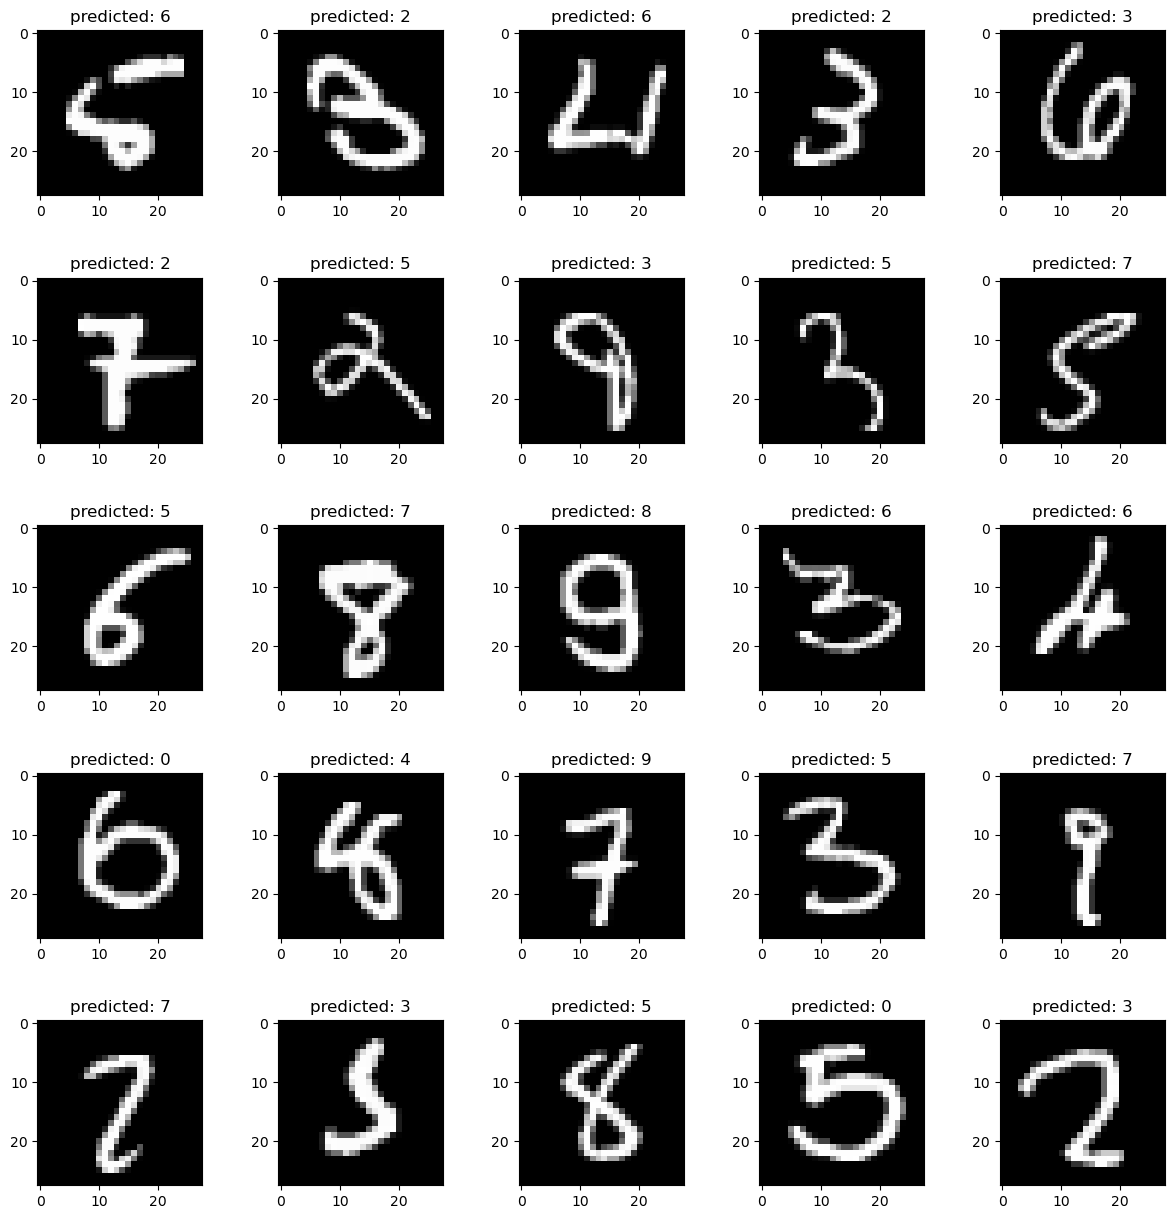

In [54]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), gridspec_kw={'hspace': 0.5})
ax = ax.flatten()

## Your code goes below
for i in range(0,25):
    ax[i].imshow(raw_test_images[wrong_indexes[i]], cmap='gray')
    ax[i].set_title("predicted: " + str(df.iloc[i,10]))


> Examine and compare the images of the misclassified digits to the probabilities of class assignment in the printed table and answer these questions:   
> 1. Notice that some of the digits shown are very poorly formed. Find a few such examples and then examine the category probabilities.    
> 2. Given the image and the probabilities describe why you think the error might have occurred?     
> **End of exercise.**     

> **Answers:**    
> 1.    there's an 8 that was predicted as a 3. The 3 had a prob of of 0.654 while 7 and 8 had a prob of 0.037 and 0.012 respectively. These probabilities are not close. However, the #2 image of a 3 was predicted as a 2 and the probabilites were very close: 0.503 for 3 and 0.430 fo 2.
> 2. Some of these images I don't understand why they were wrong. Especially the 8s and 3s. There are definitely some images that are just malformed lik the 5s and 2s. Those we may want to remove from the set. 

> **Exercise 4-7:** You may well wonder how one should choose the regularization hyperparameter for the model. The process of finding the best model for an application is know as **model selection.** In this case, answer is to perform a **hyperparameter search**. Now, do the following:   
> 1. Define a list of hyperparameter candidates, $[0.003, 0.01,0.03,0.1,0.3,1.0]$, the argument C.
> 2. Define 2 empty lists for accumulating train and test accuracy values.    
> 3. Iterate over the hyperparameter values. For each value fit a Logistic Regression model, compute the class predictions using both train and test data, and then append the train and test accuracy of the model to the associated list.   
> 4. Outside the loop compute lists (or arrays) of the train and test error rates for your model as $1.0 - accuracy$.
> 5. Display the accuracy and test error rate for each value of C.  
> 6. Execute your code, which may take some time.   

In [76]:
np.random.seed(7890)
## Put your code below
C_values = [0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
accuracy_train = [None]*len(C_values)
accuracy_test = [None]*len(C_values)
for i in range(0,len(C_values)):
    LinearClassifier = sklm.LogisticRegression(penalty='l2', C=C_values[i], multi_class='multinomial', solver ='lbfgs', max_iter=1000).fit(train_images, train_labels)
    class_predictions_train = LinearClassifier.predict(train_images)
    class_predictions_test = LinearClassifier.predict(test_images)
    accuracy_train[i] = metrics.accuracy_score(train_labels, class_predictions_train)
    accuracy_test[i] = metrics.accuracy_score(test_labels, class_predictions_test)


In [69]:
error_train = 1-np.array(accuracy_train)
error_test = 1-np.array(accuracy_test)
df = pd.DataFrame({"Training error":error_train, "Test error":error_test, "C value":C_values})
df

,Training error,Test error,C value
0,0.069500,0.0750,0.003
1,0.063900,0.0739,0.010
2,0.060000,0.0731,0.030
3,0.057500,0.0727,0.100
4,0.056600,0.0754,0.300
5,0.055883,0.0785,1.000


> 6. On a reasonable size plot area, display a graph of the hyperparameter values on the horizontal axis and the train and test errors on the vertical axis. Include a legend on your plot so you can tell which line is the test and which is the train error. *Hint:* Your plot will be easier to interpret if you use a log scale on the horizontal axis using `ax.set_xscale('log')`.  

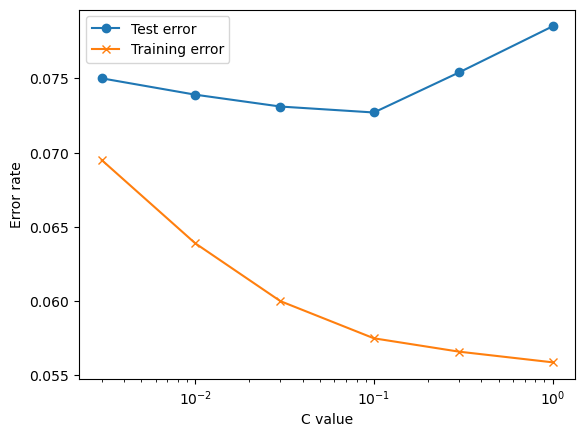

In [73]:
## Put your code below
fig, ax = plt.subplots()
ax.plot(df['C value'], df['Test error'], '-o', label="Test error")
ax.plot(df['C value'], df['Training error'], '-x', label="Training error")
ax.set_xscale('log')
ax.set_xlabel("C value")
ax.set_ylabel("Error rate")
ax.legend(loc='best')


> Examine the graph and answer the following questions:
> 1. Given the results, why do you think the hyperparameter used was selected for the model?   
> 2. What does divergence between test and training error with increasing hyperparameter value tell you about improving the generalizeability of the model?   
> **End of exercise.** 

> **Answers:**
> 1. I used a slightly different model than the one suggested for the exercise so I don't have the same results. Based on this graph, I would use the hyperparameter of 0.03 or 0.1 as those have the lowest test errors (but not by much). 
> 2. The divergence indicates overfitting of the training data, leading to reduced generalization. 

With the hyperparameter search completed we have completed the important process of **model selection**. We can now construct and test an optimal model. The code in the cell below constructs and performs evaluation on a mulit-class logistic regression model using this optimal L2 regularization hyperparameter value. Execute this code and examine the results.   

Overall accuracy = 0.9273
Average precision = 0.9271949236307915
Average recall = 0.9272999999999999
     0     1    2    3    4    5    6    7    8    9
0  956     0    1    2    0    8    7    4    2    0
1    0  1110    6    2    0    1    3    2   11    0
2    8     7  927   18   10    3   11    9   35    4
3    3     1   15  927    1   23    2   10   22    6
4    1     2    5    2  925    0   10    5    6   26
5    7     3    2   33    8  777   16   11   31    4
6   11     3    8    2    7   15  909    1    2    0
7    1     8   25    4    4    1    0  952    3   30
8    7     7    5   20    9   26    9   11  869   11
9   10     8    1    9   22    5    0   25    8  921


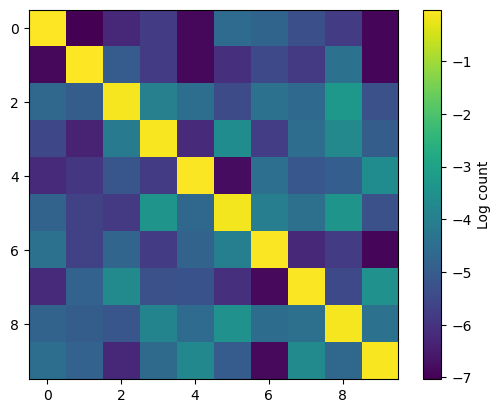

In [75]:
C = 0.03
LinearClassifier = sklm.LogisticRegression(penalty='l2', C=C, multi_class='multinomial', solver ='newton-cg').fit(train_images, train_labels)

class_predictions = LinearClassifier.predict(test_images)
class_precision = metrics.precision_score(test_labels, class_predictions, labels=unique_labels, average=None)
class_recall = metrics.recall_score(test_labels, class_predictions, labels=unique_labels, average=None)
def weighted_average(x):
    _,label_counts = np.unique(test_labels, return_counts=True)
    weights = [class_count/sum(label_counts) for class_count in label_counts]
    return sum(x*weights)
print('Overall accuracy = ' + str(metrics.accuracy_score(test_labels, class_predictions)))
print('Average precision = ' + str(weighted_average(class_precision)))
print('Average recall = ' + str(weighted_average(class_recall)))

confusion_matrix = metrics.confusion_matrix(test_labels, class_predictions)   
print(pd.DataFrame(confusion_matrix))
p = plt.imshow(np.log(np.divide(confusion_matrix + 1.0, np.sum(confusion_matrix, axis=1))))
cb = plt.colorbar(p)
_=cb.set_label('Log count')

In this case, the results are only slightly different from the model constructed with our initial regularization hyperparameter choice. This is not an unusal situation. One should not expect dramatic improvements solely from hyperparameter optimization.  However, optimizing model hyperparameters can lead to small, but useful, improvements in ML model performance.     

## Summary

We have investigated some key points of applying ML to CV problems in this lesson: 
1. The formulation of linear machine learning models. We will apply this formulation to CV problems beyond classification in subsequent lessons.     
2. A basic machine learning workflow with the following steps,   
   - Data preparation,    
   - Data repreresentation for the model,     
   - Model construction,    
   - model evaluation,    
   - and model selection.   
3. Formulation of CV features for machine learning. In this case, we used a basic approach of flattening the gray scale pixels of each image into a vector.    
4. The relationship between bias, variance and model capacity was explored through the use of regularization. Model selection was done by hyperparameter searching.  
5. Theory of binary classifiers was explored briefly.  
6. Theory of multi-class classifiers was applied to the digit classification problem. The results are probabilities for each class, with the largest probability selected as the result.    
7. Multi-class classifier evaluation was performed.     


#### Copyright  2018, 2019, 2020, 2021, 2022, 2023, 2024, Stephen F Elston. All rights reserved.  